In [1]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt

from bempp.api.assembly.blocked_operator import BlockedOperator
from numpy.linalg import slogdet
#bempp.api.enable_console_logging()

In [2]:
def get_box(nx, ny, mat, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [3]:
def get_con_box(i,mat,nboxes,n):
    BB = mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [4]:
def L(i,k,mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [5]:
def index_set(k,mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,mat,nboxes,n)[1][0:k])
    return l

In [6]:
def S(k,mat,nboxes,n):
    ll = index_set(k,mat,nboxes,n)
    mat__ = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ = get_box(i,j,mat,nboxes,n)[ll[i],:]
                mat__[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat__

In [7]:
def R(i,k,mat,nboxes,n):
    RR = np.transpose(L(i,k,mat,nboxes,n)[0])
    return RR

In [8]:
def new_S(k,mat,nboxes,n):
    mat_ = S(k,mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,mat,nboxes,n) @ np.linalg.inv(get_box(i,i,mat,nboxes,n)) @ L(i,k,mat,nboxes,n)[0])
    return mat_

In [9]:
def logdet_(k,mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,mat,nboxes,n)@np.linalg.inv(get_box(i,i,mat,nboxes,n)) @L(i,k,mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [10]:
h = .2   # size of the mesh (element)
center1 = (2, 0, 0) # center of one sphere
center2 = (-2, 0, 0) # center of the other sphere

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1) # construct the spheres
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

In [11]:
rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

snc1 = bempp.api.function_space(sphere1, "SNC", 0)
snc2 = bempp.api.function_space(sphere2, "SNC", 0)

In [12]:
N = 10
lbound = .05
ubound = 4

# We use an exponentially adapted trapezoid rule.
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
results = np.empty(N, dtype='float64')
results_appro1 = []

for index, point in enumerate(quad_points):
    
    wavenumber = -1j * np.log(point)

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

    blocked_op = BlockedOperator(2, 2)
    blocked_op[0, 0] = op11
    blocked_op[0, 1] = op12
    blocked_op[1, 0] = op21
    blocked_op[1, 1] = op22

    blocked_diag = BlockedOperator(2, 2)
    blocked_diag[0, 0] = op11
    blocked_diag[1, 1] = op22
    
    mat1 = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
    mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
    combined = np.linalg.inv(mat2).dot(mat1)
    sign, logdet = slogdet(combined)
    results[index] = logdet
    
    n = combined.shape[0]
    nboxes = 33
    size = n//nboxes
    for k in range(1,21):
        results_appro1.append(logdet_(k,combined,nboxes,n))

In [13]:
casimir_energy = np.trapz(-results / quad_points, quad_points) / (2 * np.pi)
print (casimir_energy)

0.0002563667628189509


In [14]:
Size2 = int(len(results_appro1)/N)

results_appro = np.empty([Size2,N], dtype = 'float64')
casimir_energy_appro = np.empty(Size2, dtype='float64')
relative_error_ss = np.empty(Size2, dtype='float64')

In [15]:
for i in range(Size2):
    for j in range(N):
        results_appro[i,j] = results_appro1[i+j*Size2] 
        
for p in range(Size2):
    casimir_energy_appro[p] = np.trapz(-results_appro[p,:] / quad_points, quad_points) / (2 * np.pi)   
    
for s in range(Size2):
    relative_error_ss[s] = (casimir_energy_appro[s]-casimir_energy)/casimir_energy

Text(0.5, 0, 'Rank')

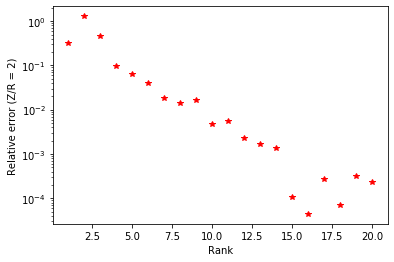

In [16]:
rank = np.linspace(1,Size2, Size2)
plt.semilogy(rank, abs(relative_error_ss),'r*')
plt.ylabel('Relative error (Z/R = 2)')
plt.xlabel('Rank')
# From the graph, if we just want a four digits approximation, we can just set the rank around 20 or above.

In [37]:
%store relative_error_ss

Stored 'relative_error_ss' (ndarray)
